In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_30 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet import *
from model.retnet.autoencoder_v5_loss_train import *
from model.retnet.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

2025-06-19 10:33:18.360860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=16,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-4)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=300, save_dir=stage1_dir, patience=50,kl_warmup_epochs=240)

[Epoch 50] KL weight: 0.0020, KL: 1.3664
[VAE Pretrain] Epoch 50/300 Avg ELBO: -392.5995 (Recon: -393.9659, KLw: 1.3664)
[Epoch 100] KL weight: 0.0041, KL: 3.0037
[VAE Pretrain] Epoch 100/300 Avg ELBO: -457.0690 (Recon: -460.0727, KLw: 3.0037)
[Epoch 150] KL weight: 0.0062, KL: 4.4484
[VAE Pretrain] Epoch 150/300 Avg ELBO: -462.2349 (Recon: -466.6833, KLw: 4.4484)
[Epoch 200] KL weight: 0.0083, KL: 5.7100
[VAE Pretrain] Epoch 200/300 Avg ELBO: -327.5827 (Recon: -333.2927, KLw: 5.7100)
[Epoch 250] KL weight: 0.0100, KL: 7.4496
[VAE Pretrain] Epoch 250/300 Avg ELBO: -515.1975 (Recon: -522.6470, KLw: 7.4496)
[Epoch 300] KL weight: 0.0100, KL: 7.3547
[VAE Pretrain] Epoch 300/300 Avg ELBO: -513.6047 (Recon: -520.9594, KLw: 7.3547)


In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30/stage1/best_vae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [5]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [6]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=90,save_dir=stage2_dir,patience=30)

[SOM] Phase 1 Epoch 10/90 Avg Loss: 0.0148
[SOM] Phase 1 Epoch 20/90 Avg Loss: 0.0148
[SOM] Phase 1 Epoch 30/90 Avg Loss: 0.0147
[SOM] Phase 2 Epoch 40/90 Avg Loss: 0.0136
[SOM] Phase 2 Epoch 50/90 Avg Loss: 0.0136
[SOM] Phase 2 Epoch 60/90 Avg Loss: 0.0136
[SOM] Phase 3 Epoch 70/90 Avg Loss: 0.0134
[SOM] Phase 3 Epoch 80/90 Avg Loss: 0.0134
[SOM] Phase 3 Epoch 90/90 Avg Loss: 0.0135


In [8]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30/stage2/best_som.pth'
model2 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

<All keys matched successfully>

In [ ]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 100,kappa= 10, beta= 150, eta= 1,
                                patience = 20)


[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Early stopping at epoch 24 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


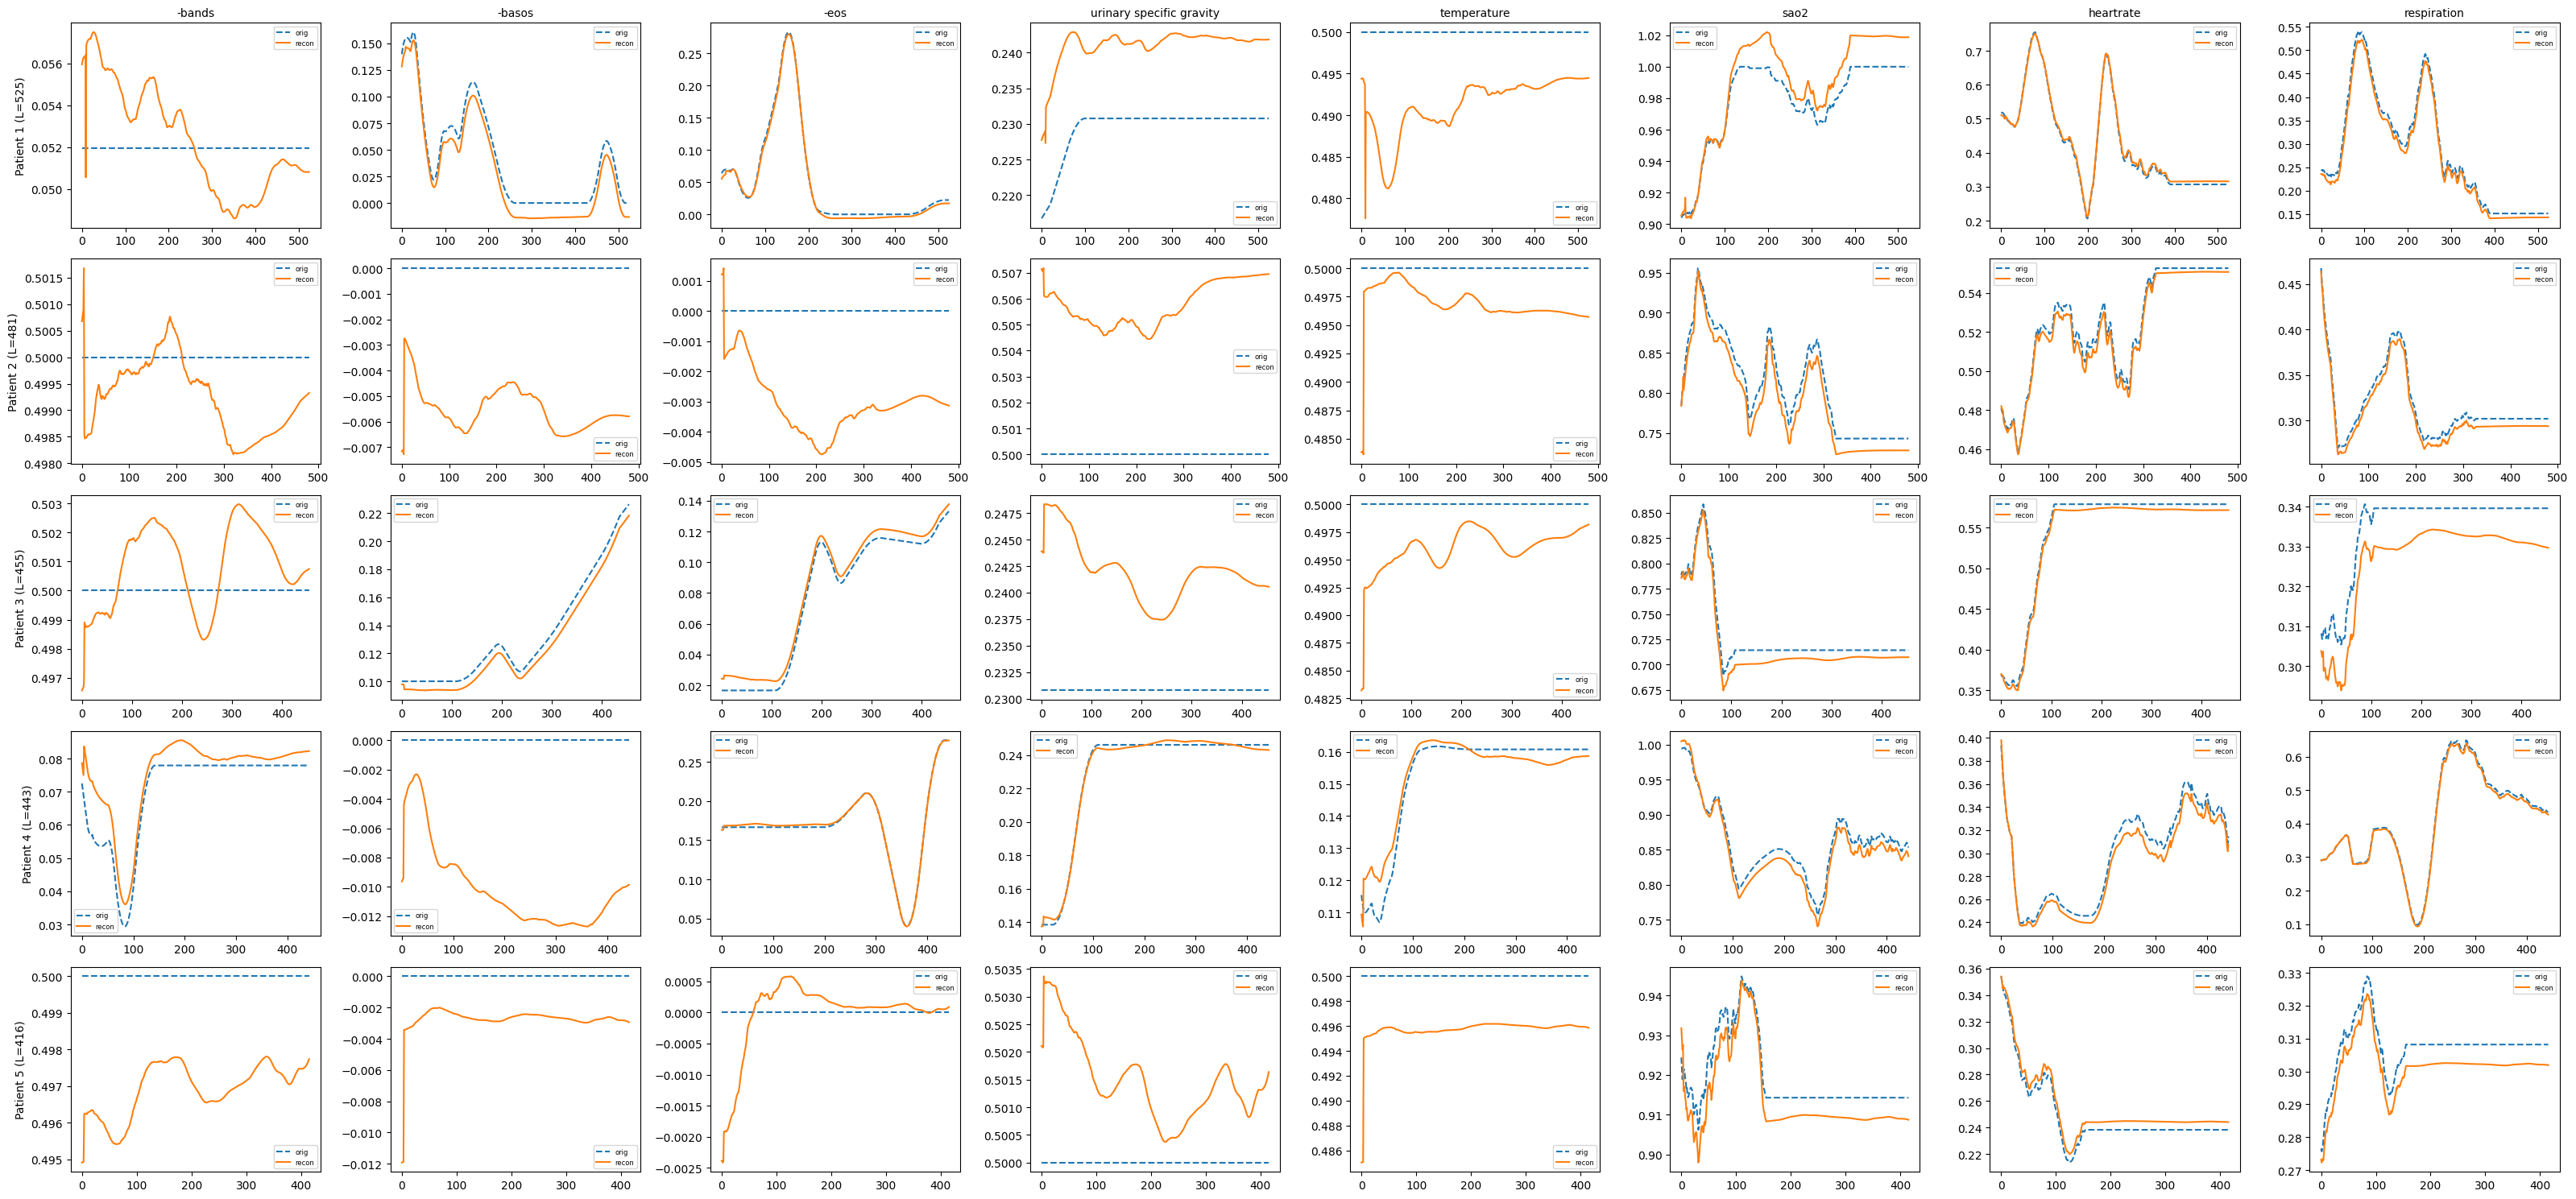

In [8]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 159530 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): -0.0195
  Std (overall): 0.2433
  Per-dim mean:
tensor([ 9.5337e-02, -4.8220e-02, -9.3397e-02, -2.1889e-02,  1.6693e-02,
         9.3435e-02,  1.0886e-01,  3.4940e-02, -1.8102e-02,  8.9144e-02,
        -4.1039e-02, -1.0811e-02, -1.5576e+00,  5.7974e-02, -1.8065e-02,
         1.6112e-02, -7.0266e-02,  1.1006e-01, -8.1478e-03,  3.3620e-02,
         1.0574e-02,  8.1151e-02, -5.7664e-02, -6.3729e-02, -9.8177e-02,
        -8.0331e-02, -2.3606e-02, -4.2175e-02,  1.0092e-01, -7.0222e-02,
        -4.4285e-02, -3.4874e-03, -1.3620e-03, -7.3612e-02, -6.2089e-02,
         2.9243e-02,  4.5543e-02, -1.6062e-02, -5.5086e-02, -2.1977e-02,
        -6.3554e-02, -1.2685e-01, -1.1346e-01,  3.3719e-03,  3.2223e-02,
        -3.2875e-02,  9.1204e-01, -7.3739e-02, -6.4229e-02,  8.9003e-02,
         1.7136e-02, -6.1461e-02,  7.6126e-02,  3.1720e-02,  2.9681e-02,
        -1.7457e-02,  1.2850e-02, -7

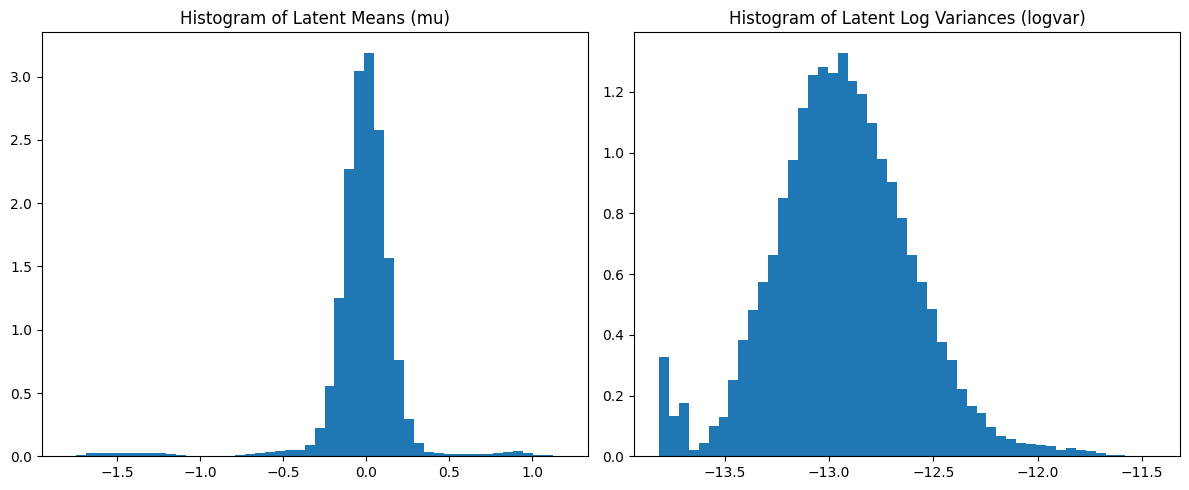

In [9]:
analyze_latent_stats(model3, train_loader, device, num_batches_to_analyze=20)

In [10]:
stage3 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30/stage3/best_joint.pth'
model3 =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model3.load_state_dict(torch.load(stage3, map_location=device,weights_only=True))

<All keys matched successfully>

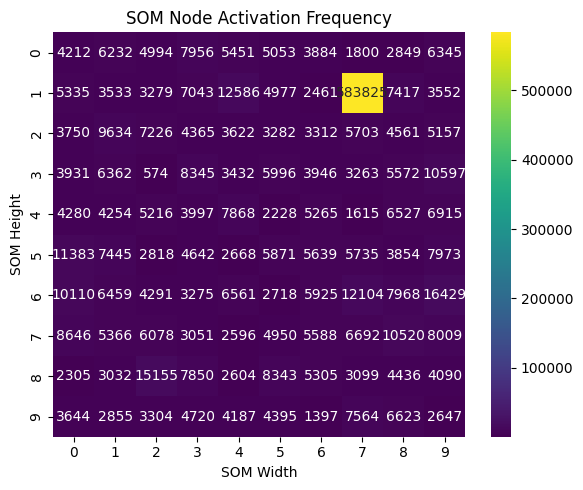

In [10]:
activation_map = compute_som_activation_heatmap(model3, train_loader, device)
plot_som_activation_heatmap(activation_map)

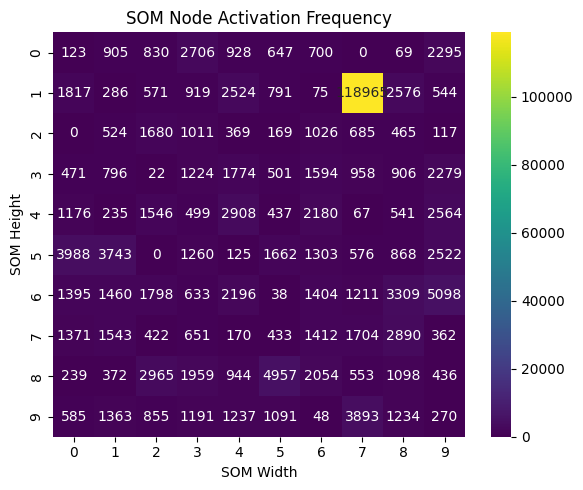

In [11]:
activation_map = compute_som_activation_heatmap(model3,test_loader, device)
plot_som_activation_heatmap(activation_map)

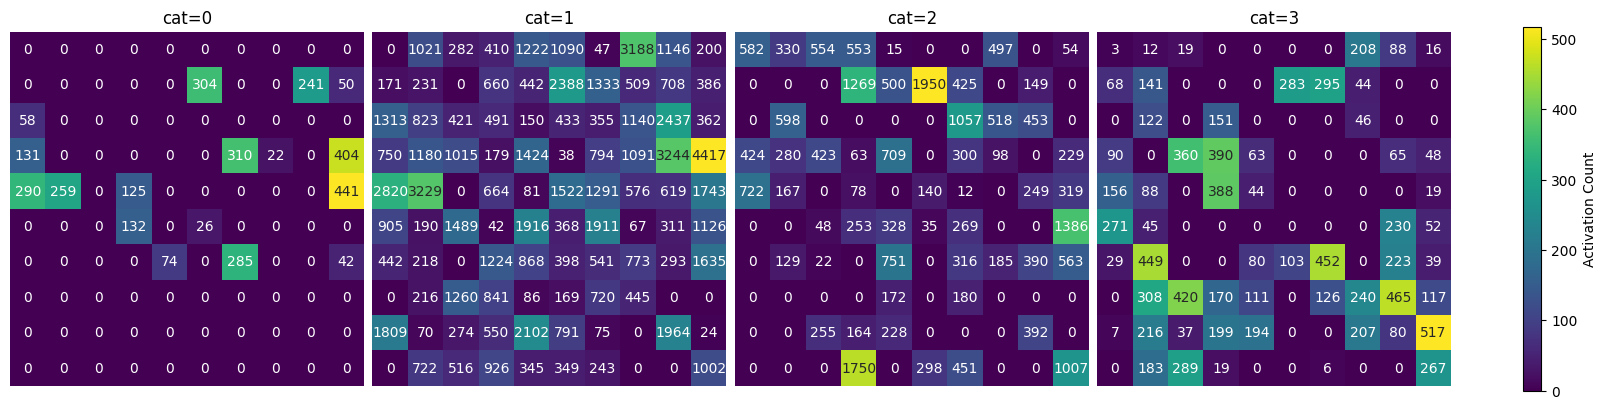

In [12]:

som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model3, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

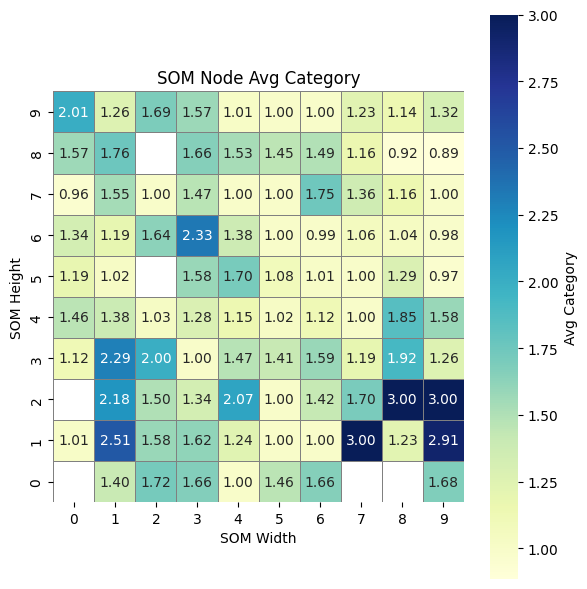

In [13]:

som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model3, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)

z_all shape: (118649, 128)
y_all shape: (118649,)


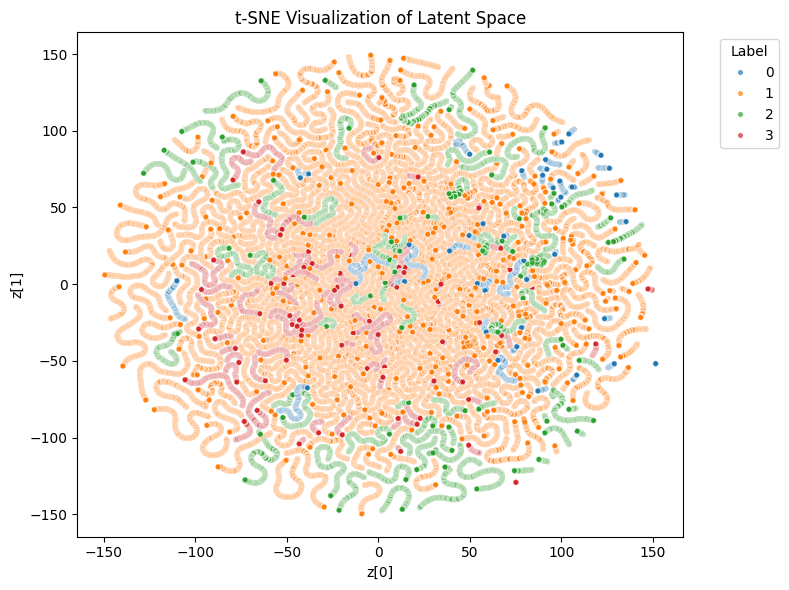

In [16]:
z_all, y_all = collect_latents(model3, data_loader=train_loader, device=device, max_batches=15)
plot_tsne(z_all, y_all)

/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


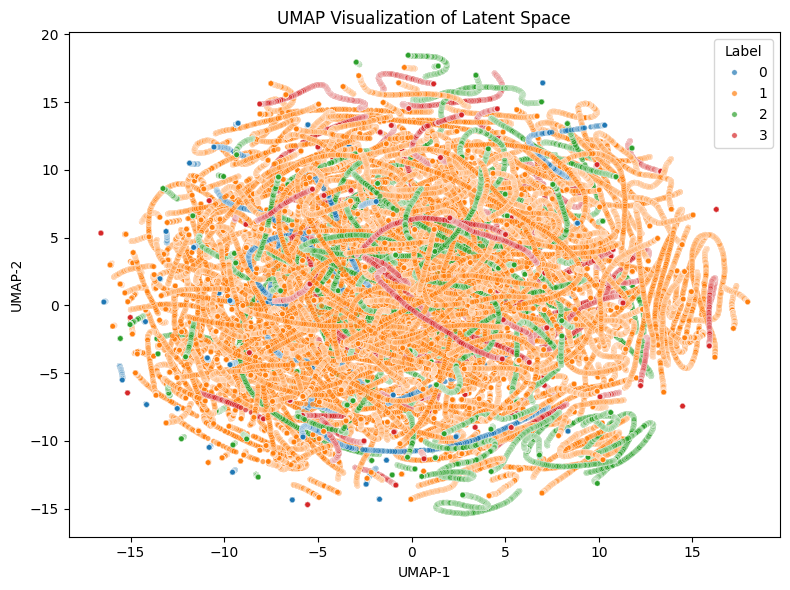

In [17]:
plot_umap(z_all, y_all)


## higher value to gamma, more weight to loss_{cah}

In [12]:
stage4_dir = os.path.join(base_dir, "stage4_higher_gamma")

model4,hist_joint =train_joint(model2, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage4_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 200, beta= 150, kappa= 10,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.



--- Latent Space Statistics ---
Analyzed 153100 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): -0.0211
  Std (overall): 0.2448
  Per-dim mean:
tensor([ 0.0836, -0.0445, -0.1019, -0.0368, -0.0206,  0.1229,  0.0857,  0.0234,
        -0.0269,  0.1097, -0.0306, -0.0198, -1.5635,  0.0984, -0.0308,  0.0087,
        -0.0327,  0.1042, -0.0225,  0.0695,  0.0081,  0.0655, -0.0664, -0.0733,
        -0.1157, -0.0801, -0.0098, -0.0478,  0.1165, -0.0679, -0.0559,  0.0074,
        -0.0022, -0.0855, -0.0477,  0.0053,  0.0502,  0.0186, -0.0563, -0.0378,
        -0.0880, -0.1189, -0.1033,  0.0325,  0.0440, -0.0247,  0.9066, -0.0824,
        -0.0859,  0.0997,  0.0241, -0.0677,  0.0801,  0.0435, -0.0033, -0.0406,
        -0.0131, -0.0760, -0.0323, -0.1029, -0.0706, -0.0230, -0.0826, -0.1111,
        -0.1686,  0.0723,  0.6321, -0.0791,  0.0908, -0.1145,  0.0151, -1.3157,
        -0.0455,  0.0842,  0.0757,  0.1043,  0.0127,  0.0948, -0.0185,  0.0506,
         0.0445, -0.0876, -0.0267,  0.0

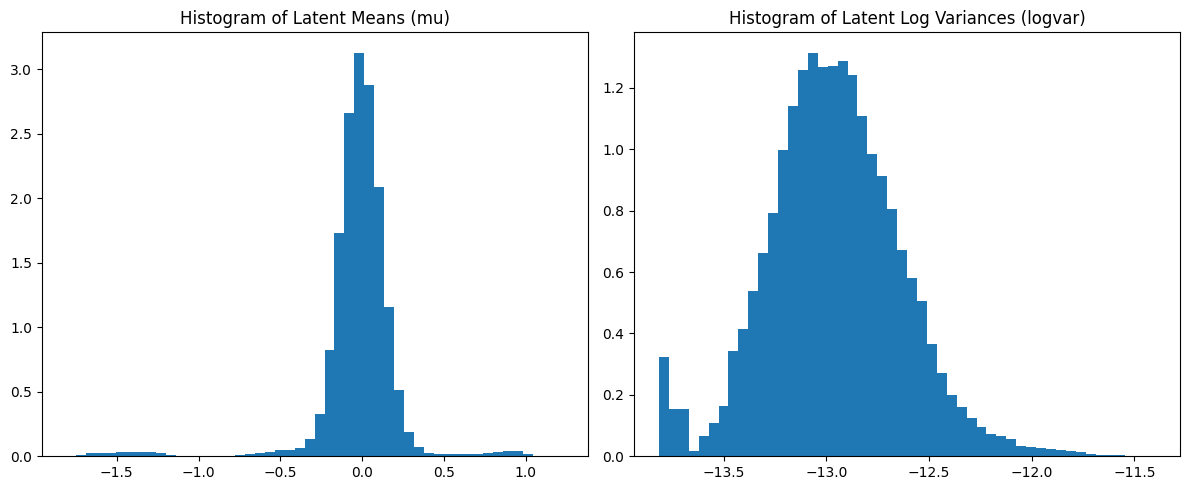

In [15]:
analyze_latent_stats(model4, train_loader, device, num_batches_to_analyze=20)

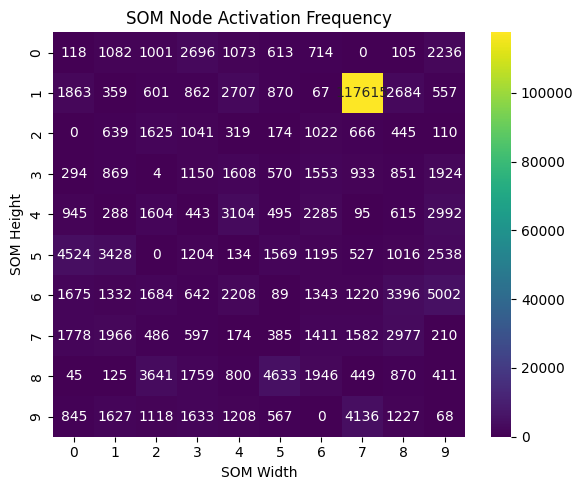

In [17]:
activation_map = compute_som_activation_heatmap(model4, test_loader, device)
plot_som_activation_heatmap(activation_map)

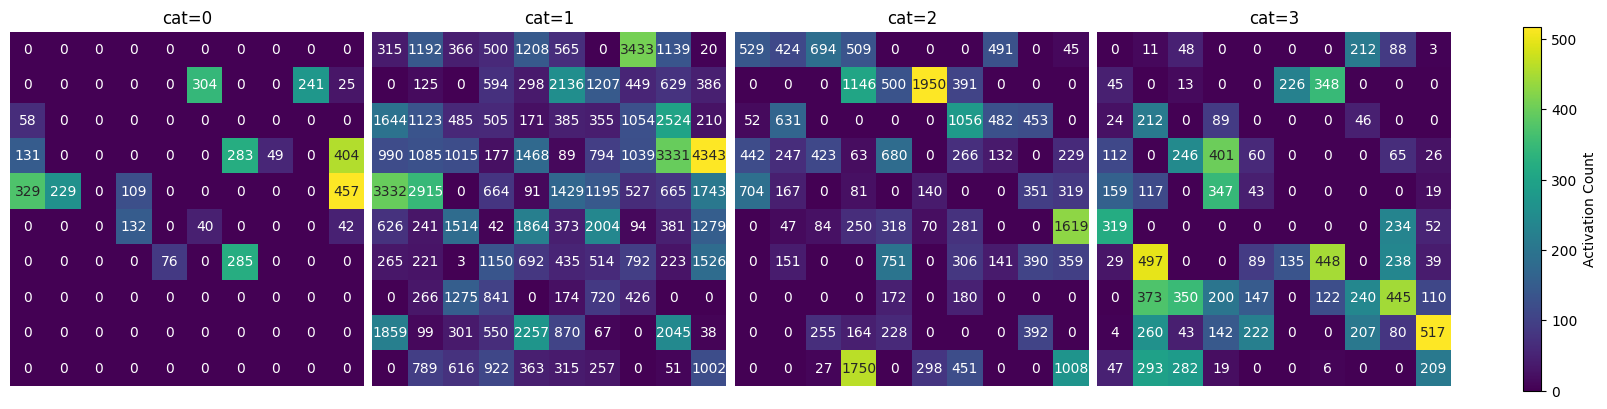

In [18]:
som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model4, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

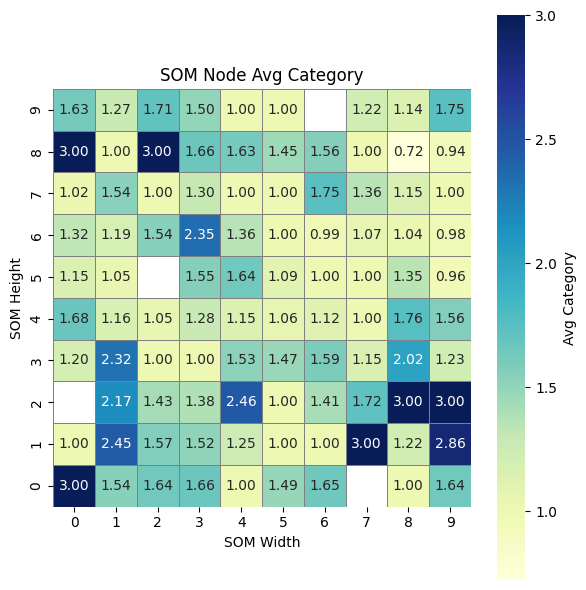

In [19]:
som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model4, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)

## higher value to beta only, L_{som} gets mor weight 

In [13]:
stage5_dir = os.path.join(base_dir, "stage5_higher_beta")

model5,hist_joint_5 =train_joint(model2, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage5_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 100, beta= 200,kappa= 10,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...


[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.



--- Latent Space Statistics ---
Analyzed 155934 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): -0.0208
  Std (overall): 0.2465
  Per-dim mean:
tensor([ 8.4349e-02, -4.9516e-02, -1.0244e-01, -2.0414e-02, -2.0006e-02,
         1.3341e-01,  9.7897e-02,  3.0323e-02, -2.6316e-02,  1.1864e-01,
        -1.6851e-02, -2.4972e-02, -1.5623e+00,  1.1557e-01, -1.8546e-02,
         1.2140e-02, -2.9599e-02,  1.1611e-01, -2.5669e-02,  7.5108e-02,
         1.2801e-02,  8.3964e-02, -3.9161e-02, -7.0611e-02, -1.2901e-01,
        -8.9623e-02, -1.4196e-02, -5.1147e-02,  1.2695e-01, -8.4415e-02,
        -5.6929e-02, -4.5231e-03,  9.9915e-03, -9.1234e-02, -4.1129e-02,
        -1.6066e-02,  5.1747e-02,  3.0186e-02, -5.9500e-02, -3.8217e-02,
        -8.2950e-02, -1.2068e-01, -1.0333e-01,  2.7237e-02,  4.0711e-02,
        -1.6552e-02,  9.0670e-01, -7.8797e-02, -8.5983e-02,  1.0324e-01,
         4.0701e-02, -7.9559e-02,  8.6689e-02,  4.9972e-02,  1.9450e-03,
        -5.0985e-02, -2.0936e-02, -7

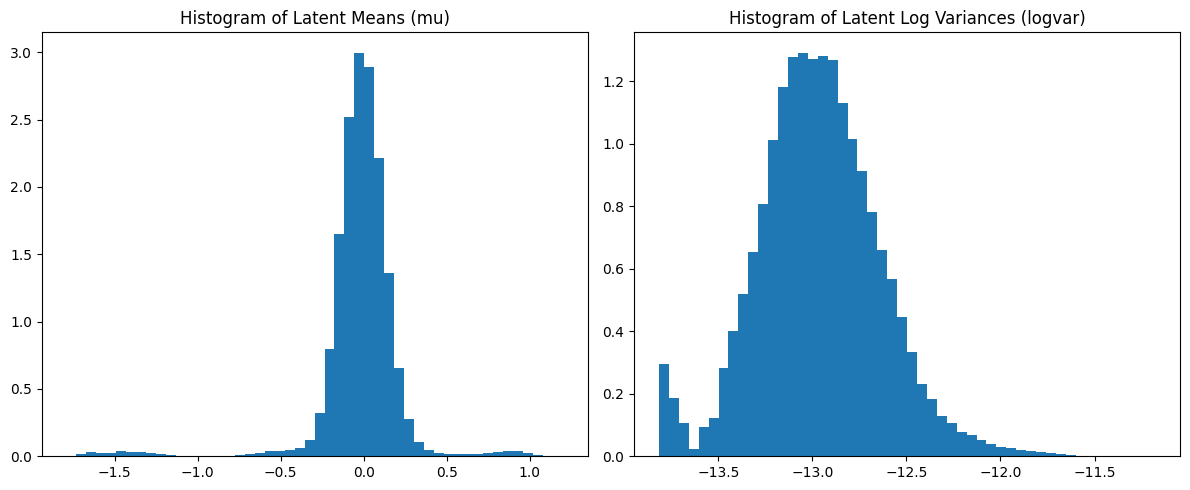

In [21]:
analyze_latent_stats(model5, train_loader, device, num_batches_to_analyze=20)

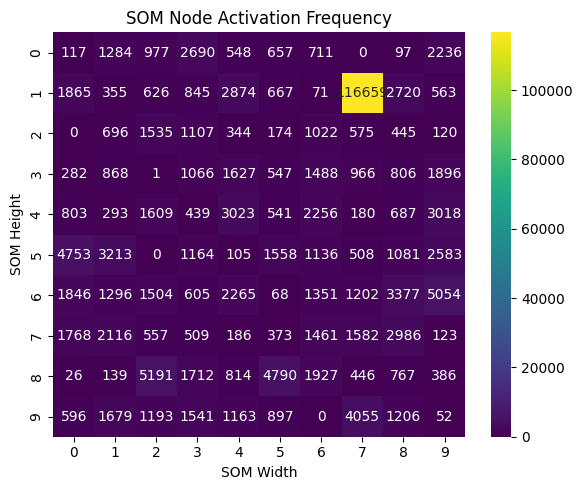

In [22]:
activation_map = compute_som_activation_heatmap(model5, test_loader, device)
plot_som_activation_heatmap(activation_map)

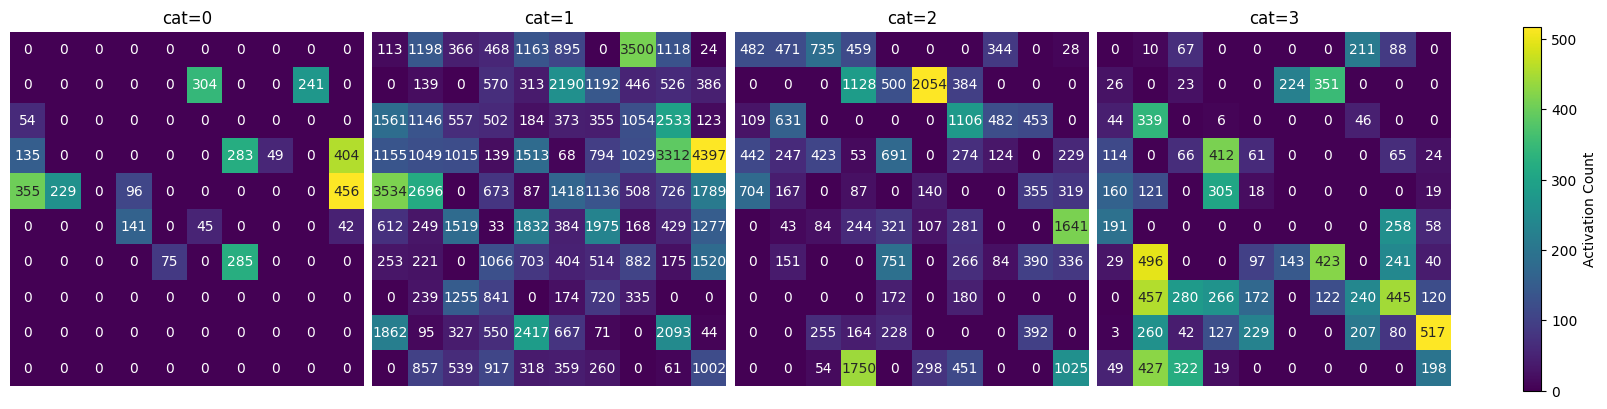

In [23]:
som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model5, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

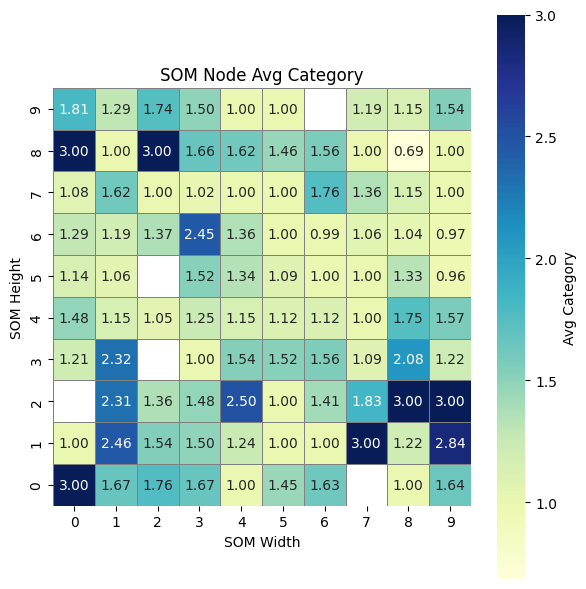

In [24]:
som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model5, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)

In [ ]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30/stage2/best_som.pth'
model2 =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

<All keys matched successfully>

## higer value to kappa， more weight to smooth

In [ ]:

stage6_dir = os.path.join(base_dir, "stage6_higher_kappa")

model6,hist_joint_6 =train_joint(model2, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage6_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 100, beta= 150, kappa= 200,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


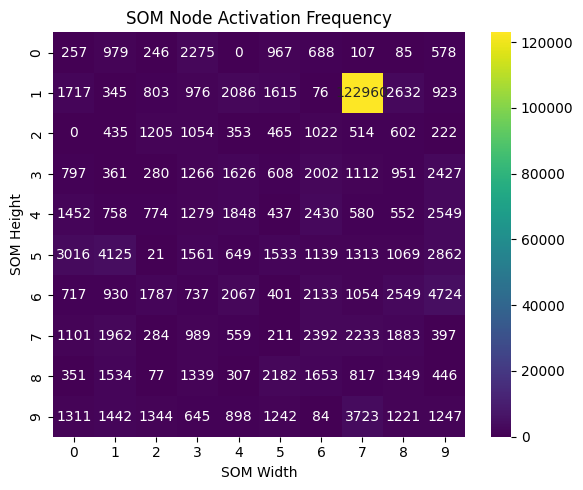

In [ ]:
activation_map = compute_som_activation_heatmap(model6, test_loader, device)
plot_som_activation_heatmap(activation_map)

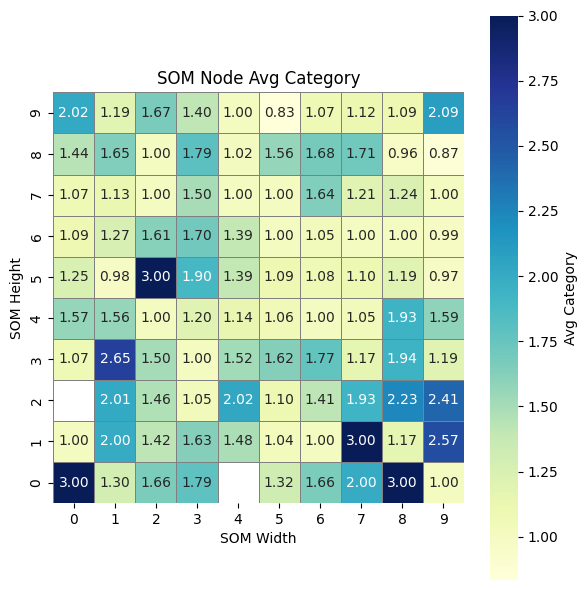

In [ ]:
som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model6, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)